# Project 5 Unsupervised Learning

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


### Objective: 

To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

### Dataset:  ALLLife bank

Data Description: Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

Apply the concepts and techniques you have learned in the previous weeks and summarize your insights at the end.

### Key Questions:

Perform EDA.
Apply Clustering Algorithms and mentions how many clusters are formed ?
How are these segments different from each other?
What are your recommendations to the bank on how to better market to and service these customers?


In [80]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme()

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering 

#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
# reading data from source
bank_data =pd.read_excel('Credit Card Customer Data.xlsx',0)

In [4]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
# droping customer key which is not needed for this analysis
bank_data.drop('Customer Key',axis=1,inplace=True)

In [6]:
bank_data.duplicated().sum()

0

In [7]:
bank_data.describe()

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


In [8]:
bank_data

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,100000,2,1,1,0
1,2,50000,3,0,10,9
2,3,50000,7,1,3,4
3,4,30000,5,1,1,4
4,5,100000,6,0,12,3
...,...,...,...,...,...,...
655,656,99000,10,1,10,0
656,657,84000,10,1,13,2
657,658,145000,8,1,9,1
658,659,172000,10,1,15,0


In [9]:
bank_data.drop('Sl_No',axis=1,inplace=True)

In [10]:
bank_data.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


### ### Observations
1. No of records is 660
2. Min credit limit is 3000 and max 200000
3. Min of one credit card to max of 10 credit cards being used.
4. There are customers who has never visited the bank. 50 percentile of customers have visited the bank 2times
5. There are customers who has never visited online capabilities. 50 percentile of customers have been to online 2times
6. There are customers who has never visited contact center capabilities. 50 percentile of customers have been to contact center 3times
7. It's unclear from the data the duration of data captured of customer interaction patterns

In [11]:
# checking missing values
bank_data.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### Observations 
The 0 or missing values in listing price has been imputed

### EDA

In [13]:
#Create a list with columns that categorical values
cat_cols=['Total_Credit_Cards', 'Total_visits_bank','Total_visits_online','Total_calls_made']


#Create a list with columns that numerical values
cont_cols = ['Avg_Credit_Limit']

In [14]:
def categorical_unigraphs(features):
    for i in bank_data[features].columns:
        #sns.barplot(tour_data[i].value_counts().index,tour_data[i].value_counts()).set_title(i)
        graph = sns.barplot(bank_data[i].value_counts().index,
                    (bank_data[i].value_counts()/len(bank_data)*100)).set_title(i)
        plt.ylim(0,100)
        plt.show()

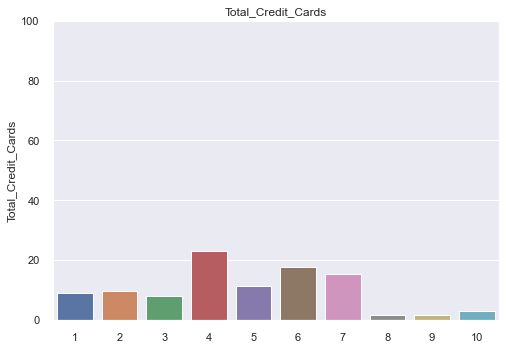

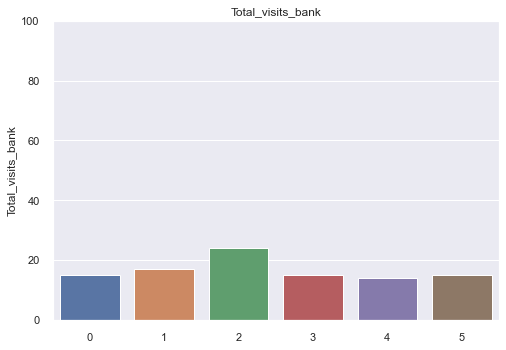

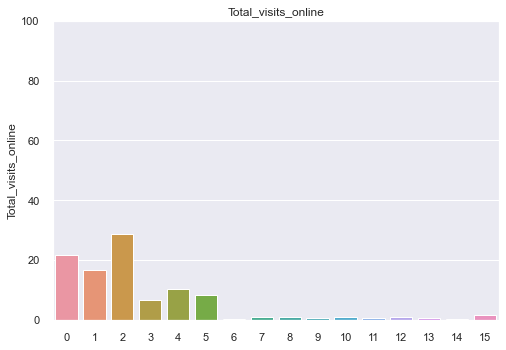

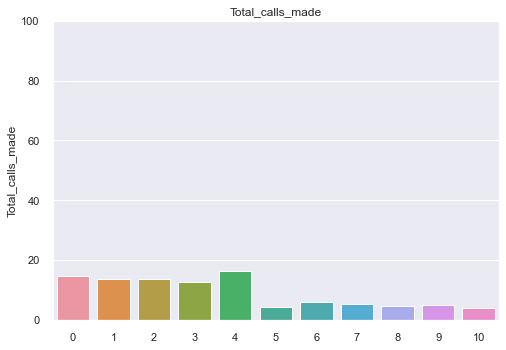

In [18]:
categorical_unigraphs(cat_cols)

In [19]:
# Univariate analysis for Continous Columns.
def continous_unigraphs(features):
    for i in bank_data[features].columns:
        sns.boxplot(bank_data[i], showmeans=True)
        plt.show()
        sns.histplot(data=bank_data, x= i , kde=True)
        plt.show()

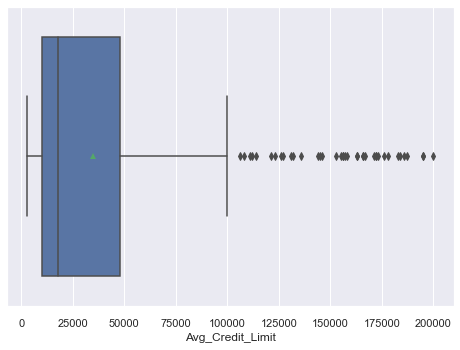

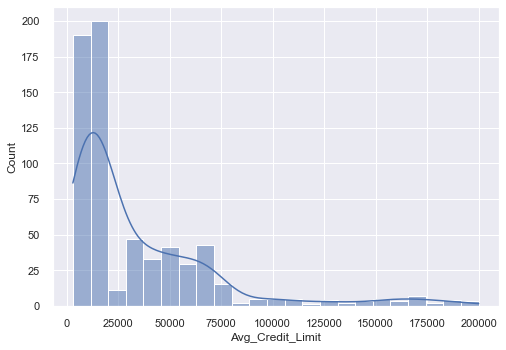

In [20]:
# Call function to print univariate graphs for continous features .
continous_unigraphs(cont_cols)

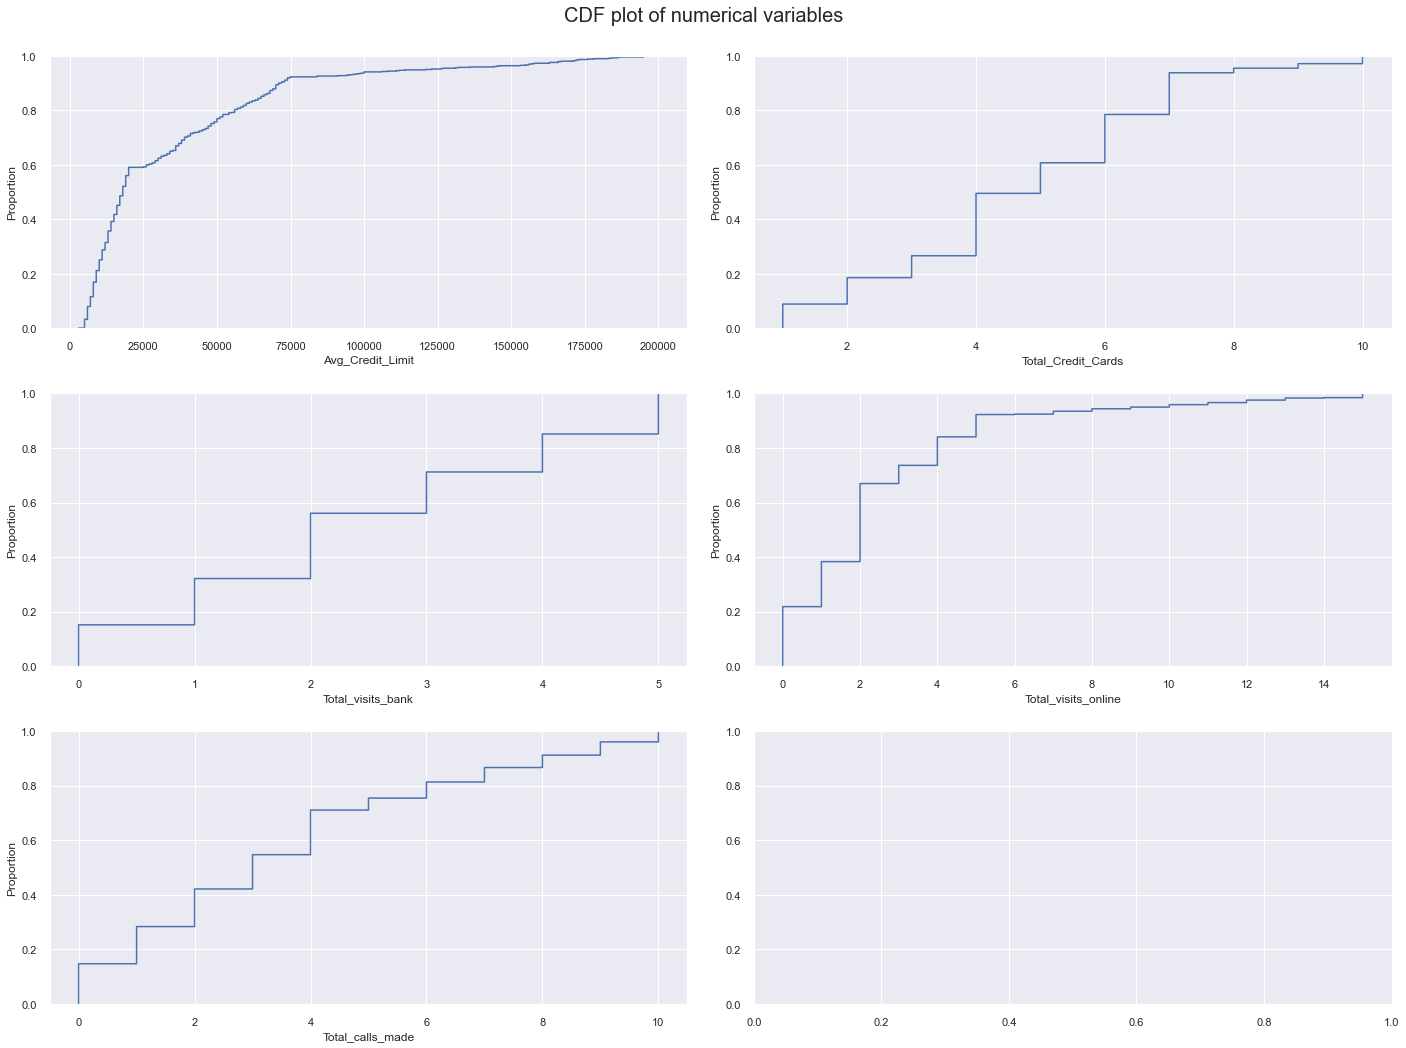

In [25]:
# select numerical columns
all_col = bank_data.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(3, 2,  figsize=(20, 15))
fig.suptitle('CDF plot of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0],x=bank_data[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1],x=bank_data[all_col[counter]])
        counter = counter+1
    else:
        pass


fig.tight_layout(pad=2.0)

#### Observations
1. 90% customers have avg credit card limit less than 75000
2. 90% customers have 7 or less credit cards
3. Visits per bank is somewhat equally distributed which ranges from 0 to 5 
4. 90% customers have 5 or less visits online capabilities. 
5. Total calls made is somewhat equally distributed population.

#### Bivariate Analysis

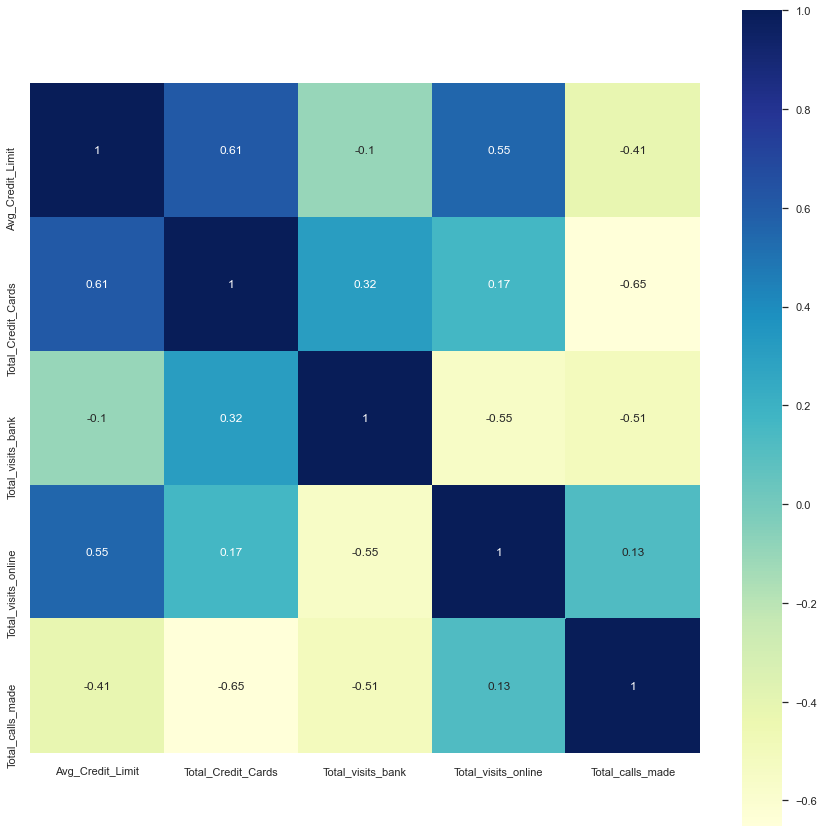

In [21]:
# Print correlation graph
plt.figure(figsize=(15,15))
sns.heatmap(bank_data.corr(),annot=True, cmap="YlGnBu", square=True);

### Observations
1. It's obvisous to see avg credit limit is highly correlated to total no of credit cards
2. Interesting to see total no of credit cards is negatively correlated to the calls made.

<AxesSubplot:xlabel='Avg_Credit_Limit', ylabel='Total_Credit_Cards'>

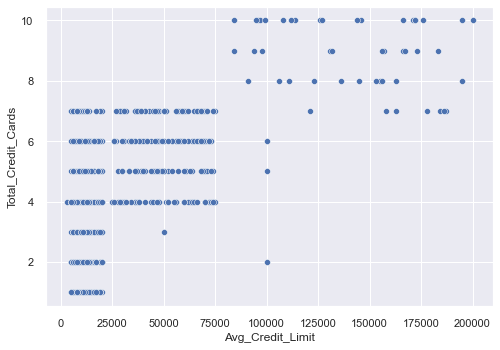

In [26]:
sns.scatterplot(x=bank_data.Avg_Credit_Limit,y=bank_data.Total_Credit_Cards)

<AxesSubplot:xlabel='Total_Credit_Cards', ylabel='Total_calls_made'>

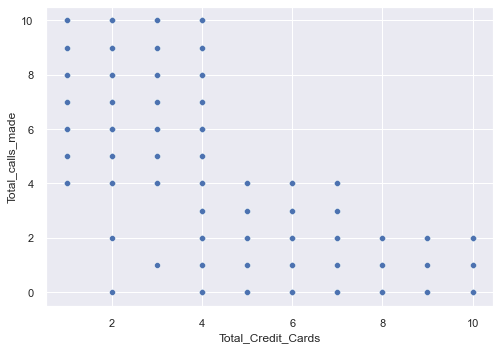

In [27]:
sns.scatterplot(x=bank_data.Total_Credit_Cards,y=bank_data.Total_calls_made)

In [28]:
all_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

## Data pre-processing

Prepare the data for analysis - Feature Engineering - Missing value Treatment - Outlier Treatment - Duplicate observations check and removal if found"

In [29]:
# Function to impute outliers
def outlier_imputer(df,feature):
    q1 = df[feature].quantile(0.25) #first quartile value
    q3 = df[feature].quantile(0.75) # third quartile value
    iqr = q3-q1 #Interquartile range
    low  = q1-1.5*iqr #acceptable range
    high = q3+1.5*iqr #acceptable range
    df = df[(df[feature] >= low) & (df[feature] <= high)] # meeting the acceptable range
    return df

In [30]:
# Function to detect outliers
def outlier_detection(df,features):
    for i in df[features].columns:
        print("Before Outlier Imputation Box plot")
        sns.boxplot(df[i], showmeans=True)
        plt.show()
        df = outlier_imputer(df, i)
        print("Post Outlier Imputation Box plot")
        sns.boxplot(df[i], showmeans=True)
        plt.show()
    return df

Before Outlier Imputation Box plot


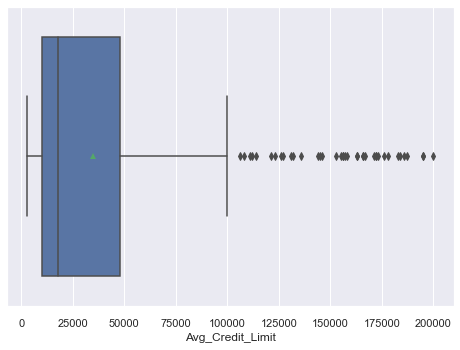

Post Outlier Imputation Box plot


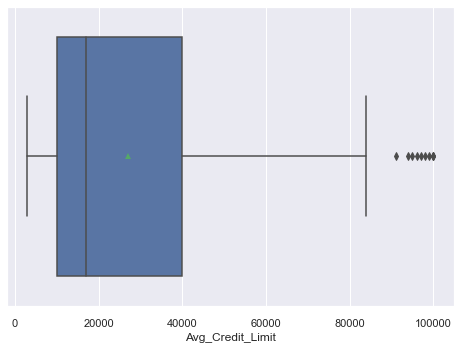

In [31]:
# Removing outlier in DurationOfPitch as it not going as it's a one off case.
bank_data = outlier_detection(bank_data, cont_cols)

In [32]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621 entries, 0 to 656
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     621 non-null    int64
 1   Total_Credit_Cards   621 non-null    int64
 2   Total_visits_bank    621 non-null    int64
 3   Total_visits_online  621 non-null    int64
 4   Total_calls_made     621 non-null    int64
dtypes: int64(5)
memory usage: 49.1 KB


In [33]:
bank_data.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [35]:
# Scaling the dataset before clustering
scaler=StandardScaler()
subset=bank_data[all_col].copy()
subset_scaled=scaler.fit_transform(subset)   

In [37]:
# Creating a dataframe of the above results
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)

Number of Clusters: 1 	Average Distortion: 2.0905232294602705
Number of Clusters: 2 	Average Distortion: 1.4332888883930412
Number of Clusters: 3 	Average Distortion: 1.3475808031680847
Number of Clusters: 4 	Average Distortion: 1.1825404120095242
Number of Clusters: 5 	Average Distortion: 1.115515702144271
Number of Clusters: 6 	Average Distortion: 1.0616747767928587
Number of Clusters: 7 	Average Distortion: 1.0215947729824262
Number of Clusters: 8 	Average Distortion: 0.9914219852578738


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

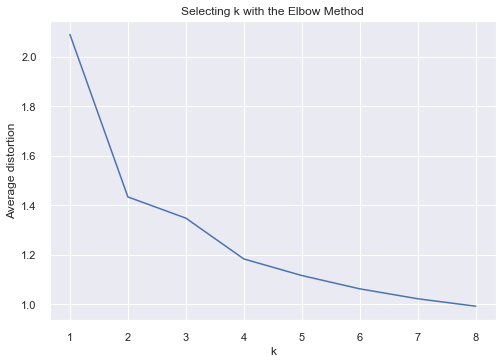

In [38]:
#Getting average clusters with distrotion
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

# 
Appropriate K seems to be 3-4

For n_clusters = 2, silhouette score is 0.48293352509063814)
For n_clusters = 3, silhouette score is 0.5058025783721007)
For n_clusters = 4, silhouette score is 0.3897699049892701)
For n_clusters = 5, silhouette score is 0.34113685035769303)
For n_clusters = 6, silhouette score is 0.23822443288496356)
For n_clusters = 7, silhouette score is 0.22528616559920425)
For n_clusters = 8, silhouette score is 0.21849268610650055)
For n_clusters = 9, silhouette score is 0.2083149641986605)


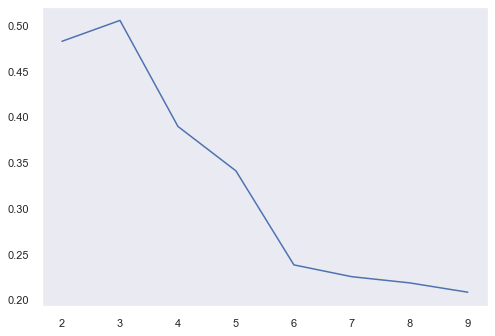

In [101]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list,sil_score)
plt.grid()

### silhouette_score for 3 is high so we take 3 as no of clusters

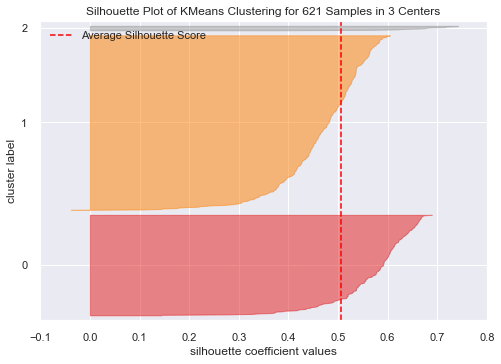

In [102]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

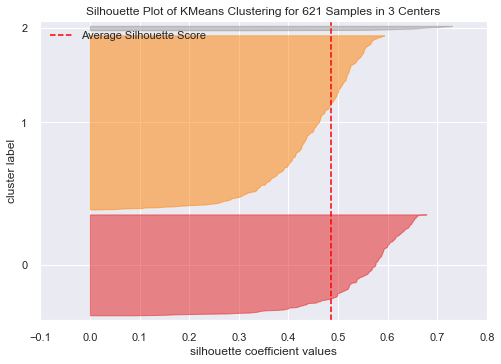

In [45]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

In [108]:
# lets us take 4 as number of clusters
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=4, random_state=0)

In [109]:
bank_data['K_means_segments'] = kmeans.labels_
subset_scaled_df['K_means_segments'] = kmeans.labels_

In [110]:
cluster_profile = bank_data.groupby('K_means_segments').mean()

In [111]:
cluster_profile['count_in_each_segments'] = bank_data.groupby('K_means_segments')['Avg_Credit_Limit'].count().values

In [112]:
# lets display cluster profile
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Clusters,count_in_each_segments
K_means_segments,,,,,,,
0,56712.500000,5.543750,3.243750,0.931250,2.075000,0.000000,160
1,12197.309417,2.403587,0.928251,3.560538,6.883408,1.004484,223
2,94363.636364,8.727273,0.636364,11.000000,1.363636,2.000000,11
3,17502.202643,5.488987,3.656388,1.022026,1.955947,0.000000,227


### Insights with Cluster as 3
Cluster 0
- average credit limit in this cluster is $33,713
- Average credit card in this cluster less than 6
- Max visits to the bank is 3, visits online is 1, calls made is 2
- no of customers in this cluster is 387
- In this clusters the customers prefer visiting bank and contacting call centers as opposed to visiting online.

Cluster 1
- Average credit limit in this cluster is $12K 
- Customers prefe calling contact center and visiting online as opposed to visiting the bank.
- no of customers in this cluster is 222

Cluster 2
- Average credit limit in this cluster is $90K
- Average credit card in this segement is 8. 
- customers in this segement prefer visiting online and contacting call centers as opposed to visiting bank. 



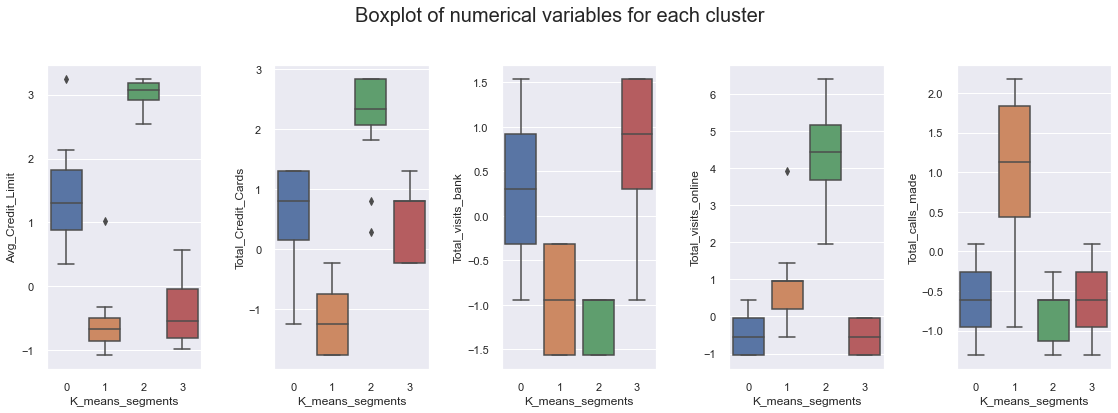

In [116]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

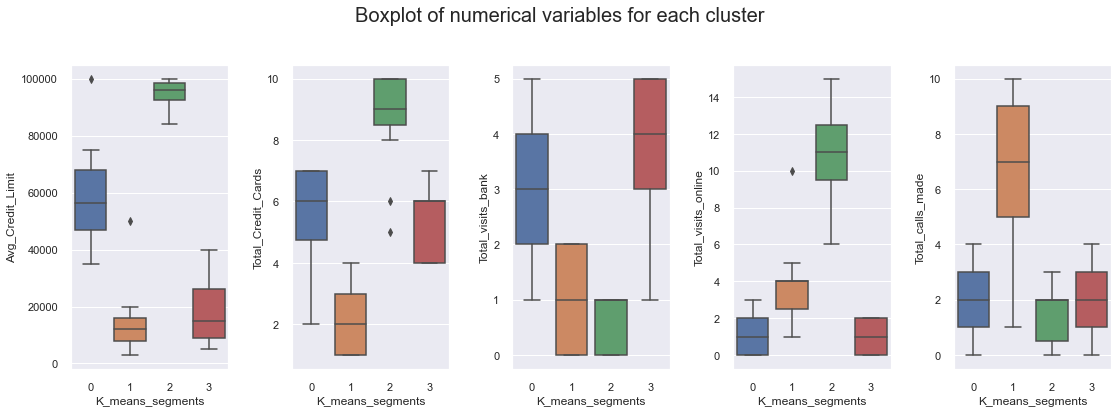

In [117]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=bank_data[all_col[counter]],x=bank_data['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0) 

In [119]:
# lets display cluster profile
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Clusters,count_in_each_segments
K_means_segments,,,,,,,
0,56712.500000,5.543750,3.243750,0.931250,2.075000,0.000000,160
1,12197.309417,2.403587,0.928251,3.560538,6.883408,1.004484,223
2,94363.636364,8.727273,0.636364,11.000000,1.363636,2.000000,11
3,17502.202643,5.488987,3.656388,1.022026,1.955947,0.000000,227


### Insights with Cluster as 4
Cluster 0
- average credit limit in this cluster is $58,712
- Average credit card in this cluster less than 6
- Max visits to the bank is 3, visits online is 1, calls made is 2
- no of customers in this cluster is 160
- In this clusters the customers prefer visiting bank and contacting call centers as opposed to visiting online.

Cluster 1
- Average credit limit in this cluster is $12K 
- Customers prefer calling contact center and visiting online as opposed to visiting the bank.
- no of customers in this cluster is 223

Cluster 2
- Average credit limit in this cluster is $94K
- Average credit card in this segement is 8. 
- customers in this segement prefer visiting online and contacting call centers as opposed to visiting bank. 


Cluster 3
- Average credit limit in this cluster is $17K
- Average credit card in this segement is 5. 
- customers in this segement prefer visiting bank rather than reaching online and calls made

### Applying Hierarchical clustering
Apply Hierarchical clustering with different linkage methods - Plot dendrograms for each linkage methods - Choose appropriate number of cluster"

In [67]:
all_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [69]:
# Scaling the dataset before clustering
scaler=StandardScaler()
subset=bank_data[all_col].copy()
subset_scaled = scaler.fit_transform(subset)  

In [70]:
# Creating a dataframe of the above results
subset_scaled_df = pd.DataFrame(subset_scaled,columns=subset.columns)

In [71]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(subset_scaled_df))
        print('Cophent correlation for distance metrics {} and linkahe method {} is {}'.format(dm,lm,c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophent correlation for distance metrics euclidean and linkahe method single is 0.5492278027329672
Cophent correlation for distance metrics euclidean and linkahe method complete is 0.825691025264852
Cophent correlation for distance metrics euclidean and linkahe method average is 0.8628327198501938
Cophent correlation for distance metrics euclidean and linkahe method weighted is 0.8579397371631392
Cophent correlation for distance metrics chebyshev and linkahe method single is 0.5637872207799998
Cophent correlation for distance metrics chebyshev and linkahe method complete is 0.8010640149975625
Cophent correlation for distance metrics chebyshev and linkahe method average is 0.8522331000982138
Cophent correlation for distance metrics chebyshev and linkahe method weighted is 0.852639435533819
Cophent correlation for distance metrics mahalanobis and linkahe method single is 0.5340049071526733
Cophent correlation for distance metrics mahalanobis and linkahe method complete is 0.6030853906262

In [72]:
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Highest cophenet correlation is 0.8628327198501938, which is obtinaed with euclidean distance metric and average linkage method


In [73]:
linkage_methods = ['single', 'complete', 'average','median','ward', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(subset_scaled_df))
    print('Cophent correlation for distance metrics {} and linkahe method {} is {}'.format('euclidean',lm,c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = dm
        high_dm_lm[1] = lm
print('*'*110)
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Cophent correlation for distance metrics euclidean and linkahe method single is 0.5492278027329672
Cophent correlation for distance metrics euclidean and linkahe method complete is 0.825691025264852
Cophent correlation for distance metrics euclidean and linkahe method average is 0.8628327198501938
Cophent correlation for distance metrics euclidean and linkahe method median is 0.8527355421595066
Cophent correlation for distance metrics euclidean and linkahe method ward is 0.697586710796668
Cophent correlation for distance metrics euclidean and linkahe method weighted is 0.8579397371631392
**************************************************************************************************************
Highest cophenet correlation is 0.8628327198501938, which is obtinaed with cityblock distance metric and average linkage method


### Observation
we see that cophenet index is maximum with cityblock distance metric which manhattan distance method and average linkage method. 

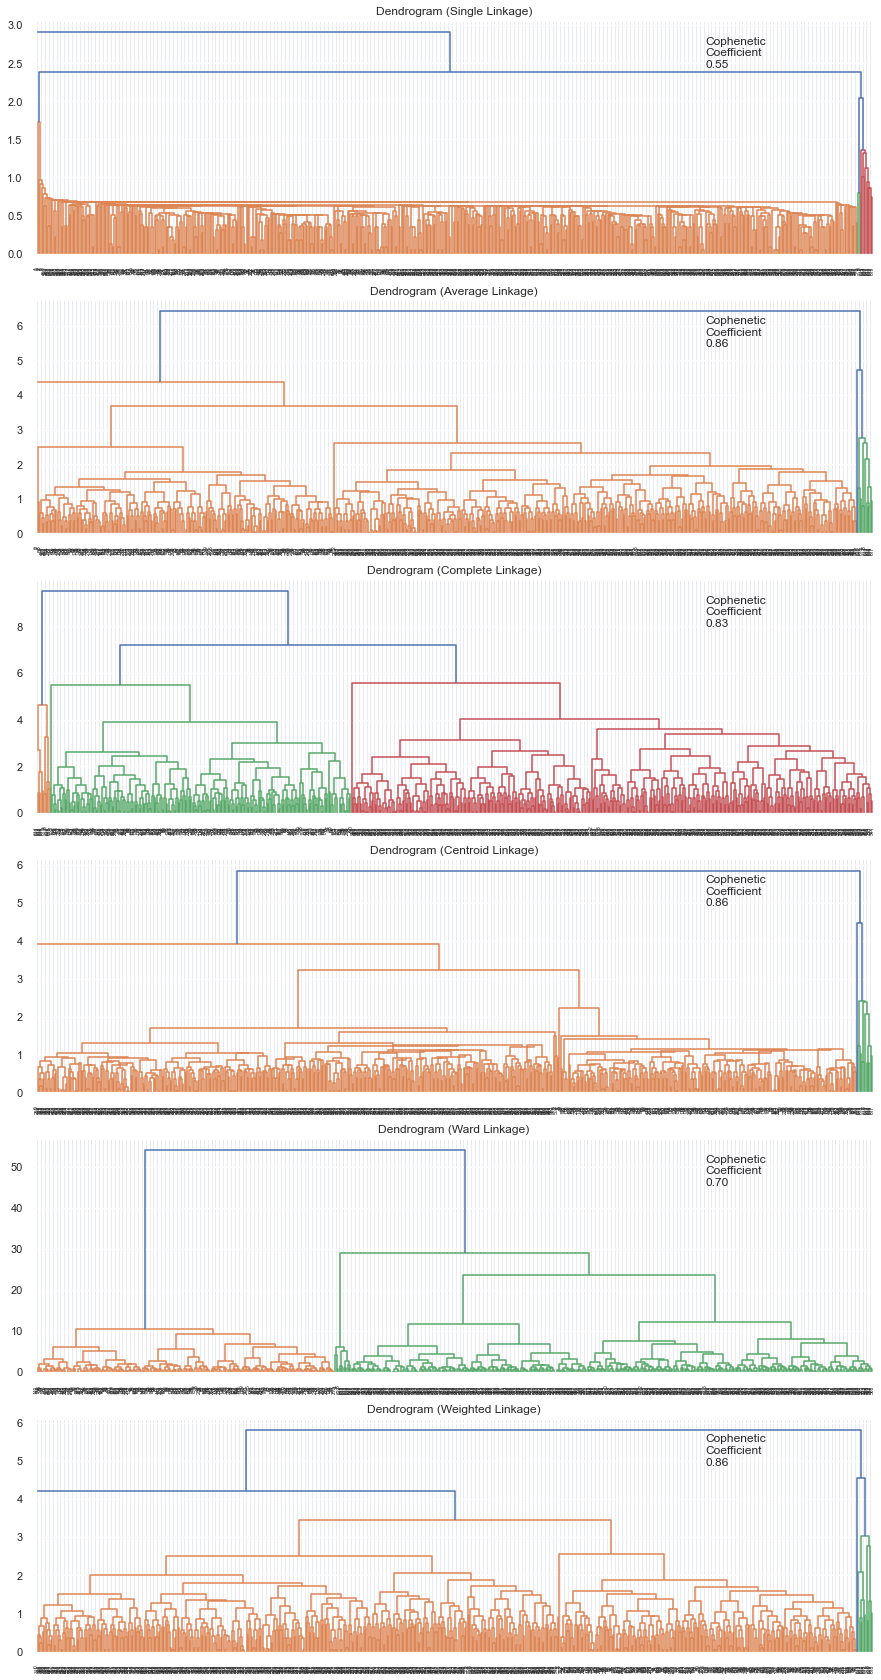

In [74]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])

### Observations
Dendrogram with ward linkage method shows distinct and separate cluster
 

In [75]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.549228
1,average,0.862833
2,complete,0.825691
3,centroid,0.859487
4,ward,0.697587
5,weighted,0.857940


In [76]:
distance_metrics = [ 'mahalanobis','cityblock']
linkage_methods = ['average', 'weighted']

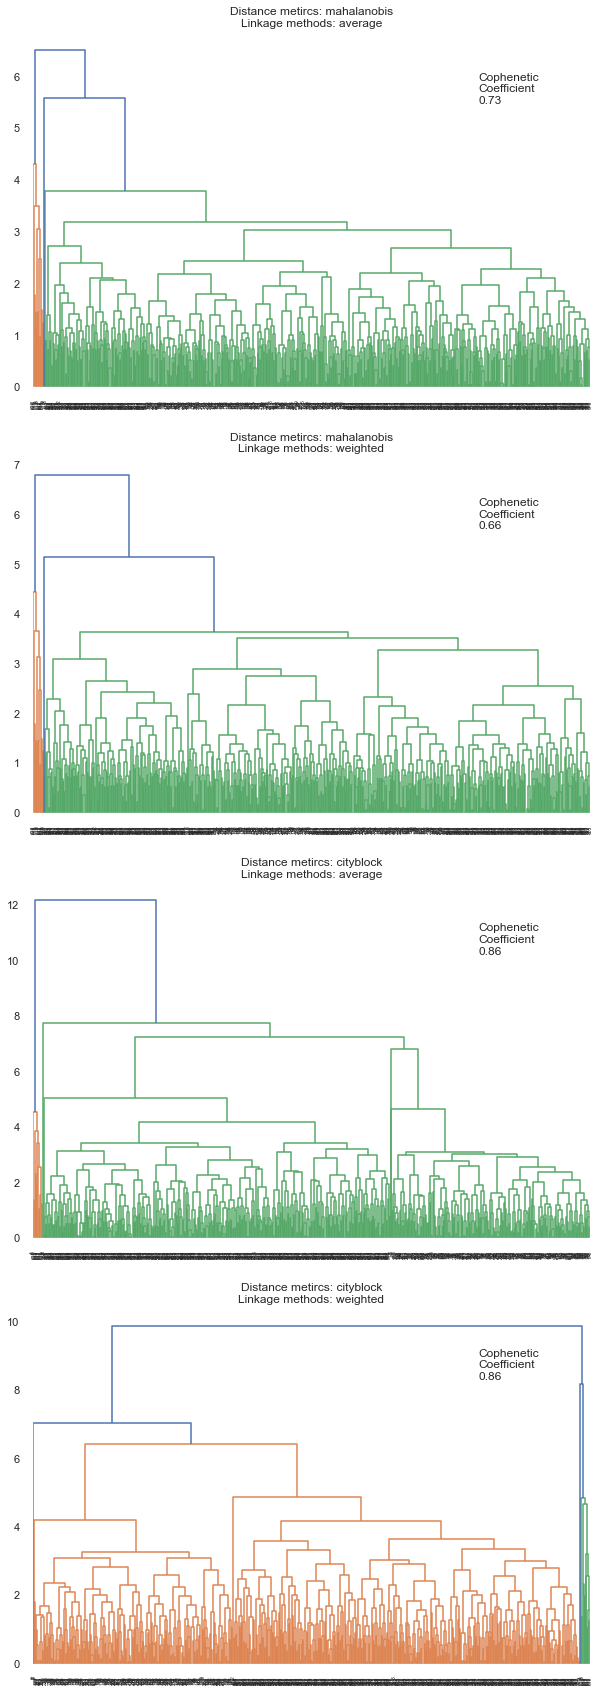

In [77]:
# Create a subplot image
fig, axs = plt.subplots(len(distance_metrics)+len(distance_metrics), 1, figsize=(10, 30))
i=0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        dendrogram(Z,  ax=axs[i]);
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))
        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                        (0.80, 0.80),
                        xycoords='axes fraction')
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))                        
        i +=1

### Observations
Out of all the dendrogram we saw, it is clear that dendrogram with ward linkage method gave us separate and distinct clusters
3 cluster would be appropriate number of cluster from dendrogram with ward linkage method  

In [81]:
#Trying with K value as 3
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='ward')
HCmodel.fit(subset_scaled_df)
subset_scaled_df['HC_Clusters'] = HCmodel.labels_

In [83]:
bank_data['HC_Clusters'] = HCmodel.labels_

In [105]:
cluster_profile1 = bank_data.groupby('HC_Clusters').mean()

In [106]:
cluster_profile1['count_in_each_segments'] = bank_data.groupby('HC_Clusters')['Avg_Credit_Limit'].count().values

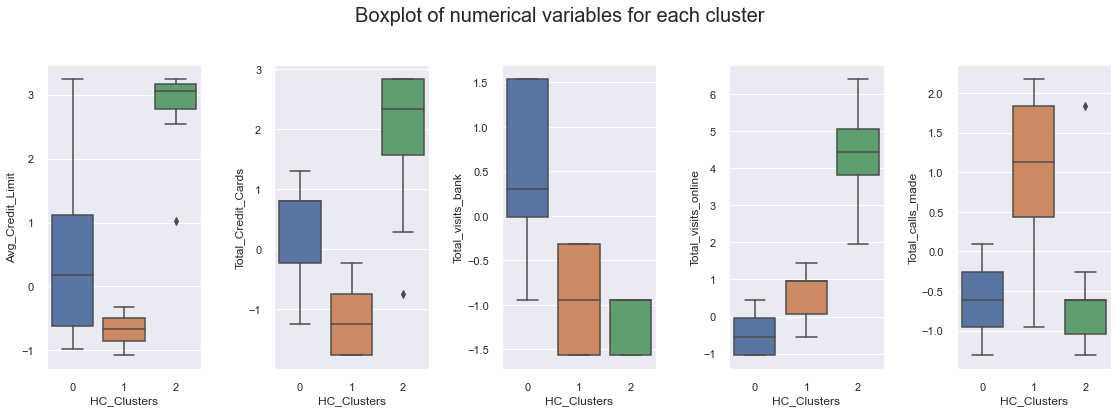

In [90]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

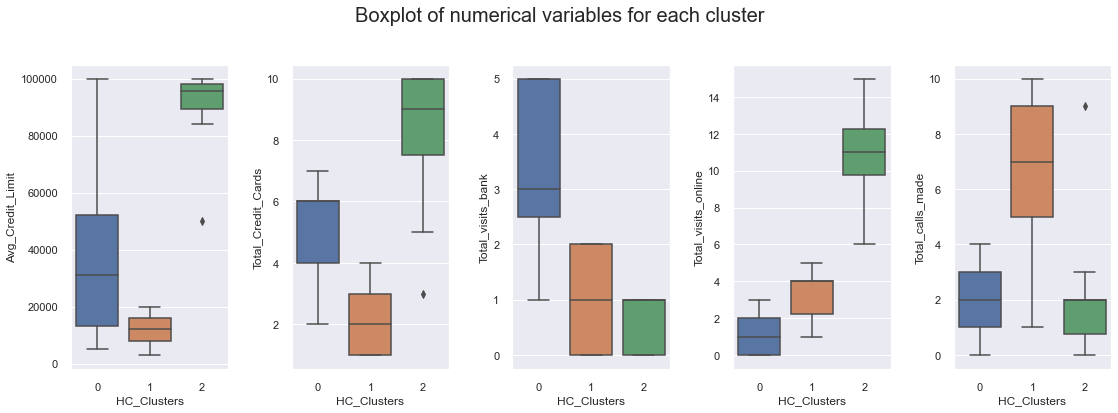

In [94]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=bank_data[all_col[counter]],x=bank_data['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

In [120]:
# lets display cluster profile
cluster_profile1.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584,387
1,12027.027027,2.400901,0.932432,3.531532,6.873874,1.000000,222
2,90666.666667,8.250000,0.583333,10.916667,2.000000,1.916667,12


### Insights

Cluster 0
- avg credit limit is 33K
- customers prefer visiting bank than visiting online and contacting call center

Cluster 1
- avg credit limit is 12k
- customers prefer calling and visiting online than visiting bank

cluster 0 
- avg credit limit is 90k
- customers prefer visiting online than calls and visitng bank. 


# Business recommendations

Based on various custer techniques applied above in general, customers more than 50% prefer visiting bank still. So the business should focus on increasing capabilities in the branch to resolve queries quicker

Secondly, around 35% of customers prefer contacting contact centers.

Thirdly a very few customers prefer working online. This may be due to challanges in the online capabilities may be it's not user friend. The business should focus on improving online capabilites to ensure customers have better end user experience in use of online capabilities.